# Import Libraries & Load Dataset


In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

# Load Dataset (uploaded file)
df = pd.read_csv(r"E:\A\OneDrive\Documents\3rd year\5th SEM Materials of SR.Mishra(3rd yr)\Machine Learning for Predictive Analytics\Project\1\Dataset\archive (1)\ecommerce_customer_data_custom_ratios.csv")

print("✅ Original Shape:", df.shape)
df.head()


E:\A\OneDrive\Documents\3rd year\python\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


✅ Original Shape: (250000, 13)


,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Purchased
0,46251,08-09-2020 09:38,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,05-03-2022 12:56,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,23-05-2022 18:18,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,12-11-2020 13:13,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,27-11-2020 17:55,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


# Data Preprocessing


In [2]:
# Check missing values
print("\nMissing values before cleaning:\n", df.isnull().sum())

# Remove missing values
df = df.dropna()

# Remove duplicates
df = df.drop_duplicates()

# Remove invalid transactions (if Quantity/UnitPrice exist)
if "Quantity" in df.columns and "UnitPrice" in df.columns:
    df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Convert dates
if "InvoiceDate" in df.columns:
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

# Convert CustomerID to int (if exists)
if "CustomerID" in df.columns:
    df["CustomerID"] = df["CustomerID"].astype(int)

print("\nMissing values after cleaning:\n", df.isnull().sum())
print("✅ Shape after preprocessing:", df.shape)


Missing values before cleaning:
 Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47596
Customer Name                0
Age                          0
Gender                       0
Purchased                    0
dtype: int64

Missing values after cleaning:
 Customer ID              0
Purchase Date            0
Product Category         0
Product Price            0
Quantity                 0
Total Purchase Amount    0
Payment Method           0
Customer Age             0
Returns                  0
Customer Name            0
Age                      0
Gender                   0
Purchased                0
dtype: int64
✅ Shape after preprocessing: (202404, 13)


# Feature Engineering

In [3]:
if "Quantity" in df.columns and "UnitPrice" in df.columns:
    df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

# Extract date-based features
if "InvoiceDate" in df.columns:
    df["InvoiceMonth"] = df["InvoiceDate"].dt.month
    df["InvoiceDay"] = df["InvoiceDate"].dt.day
    df["InvoiceHour"] = df["InvoiceDate"].dt.hour

# Encode categorical features (like Country)
if "Country" in df.columns:
    le = LabelEncoder()
    df["Country_Code"] = le.fit_transform(df["Country"])

# Define target variable (example: Purchased if Quantity >= 5)
if "Quantity" in df.columns:
    df["Purchased"] = (df["Quantity"] >= 5).astype(int)

print("✅ Feature Engineering Done")
df.head()

✅ Feature Engineering Done


,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Purchased
0,46251,08-09-2020 09:38,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,05-03-2022 12:56,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,23-05-2022 18:18,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,12-11-2020 13:13,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,27-11-2020 17:55,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,0


# Define Features and Target


In [4]:

# Drop unnecessary columns if present
drop_cols = [
    "InvoiceNo", "StockCode", "Description", "InvoiceDate",
    "Country", "Purchased"
]
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
y = df["Purchased"]

# Avoid leakage
X = X.drop(columns=["Quantity", "TotalPrice"], errors="ignore")

print("✅ Features shape:", X.shape)
print("✅ Target shape:", y.shape)

✅ Features shape: (202404, 11)
✅ Target shape: (202404,)


# Train-Test Split

In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)

Training set: (161923, 11)
Test set: (40481, 11)


# Feature Scaling (Fixed)

In [6]:

# Keep only numeric columns for scaling
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("✅ Scaling done. X_train shape:", X_train.shape)

✅ Scaling done. X_train shape: (161923, 6)


# Feature Selection

In [7]:

selector = SelectKBest(score_func=f_classif, k="all")
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)

print("✅ X_train shape after selection:", X_train.shape)

✅ X_train shape after selection: (161923, 6)


# Define Models and Hyperparameters


In [8]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": LinearSVC(max_iter=5000)
}

param_grid = {
    "Logistic Regression": {"C": [0.01, 0.1, 1, 10]},
    "Random Forest": {"n_estimators": [50, 100, 200], "max_depth": [5, 10, None]},
    "Decision Tree": {"max_depth": [5, 10, None], "criterion": ["gini", "entropy"]},
    "KNN": {"n_neighbors": [3, 5, 7, 11]},
    "SVM": {"C": [0.01, 0.1, 1, 10]}
}

# Train Models with Hyperparameter Tuning + Confusion Matrices


===== Logistic Regression =====
Best Parameters: {'C': 10}
Accuracy: 0.8029692942368024
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     32505
           1       0.00      0.00      0.00      7976

    accuracy                           0.80     40481
   macro avg       0.40      0.50      0.45     40481
weighted avg       0.64      0.80      0.72     40481



C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

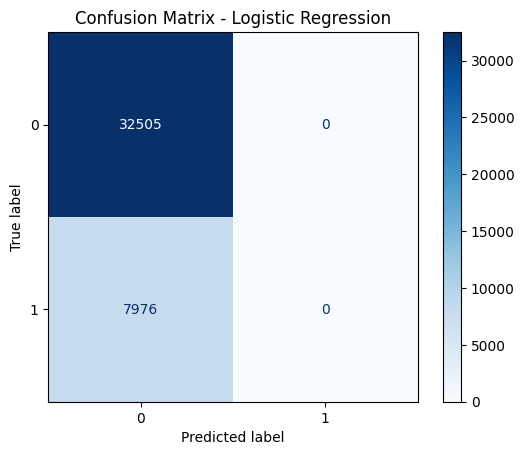


===== Random Forest =====
Best Parameters: {'max_depth': 5, 'n_estimators': 200}
Accuracy: 0.8029692942368024
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     32505
           1       0.00      0.00      0.00      7976

    accuracy                           0.80     40481
   macro avg       0.40      0.50      0.45     40481
weighted avg       0.64      0.80      0.72     40481



C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

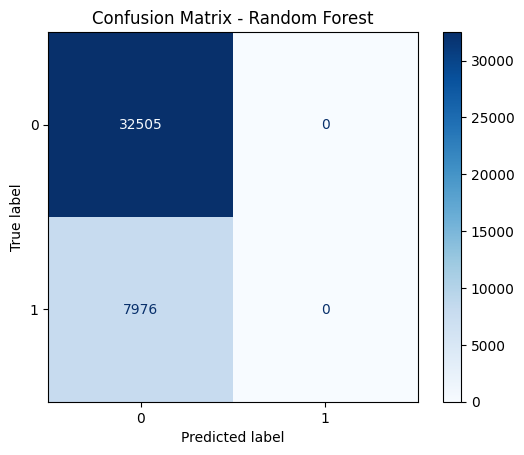


===== Decision Tree =====
Best Parameters: {'criterion': 'entropy', 'max_depth': 5}
Accuracy: 0.8028704824485561
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     32505
           1       0.00      0.00      0.00      7976

    accuracy                           0.80     40481
   macro avg       0.40      0.50      0.45     40481
weighted avg       0.64      0.80      0.72     40481



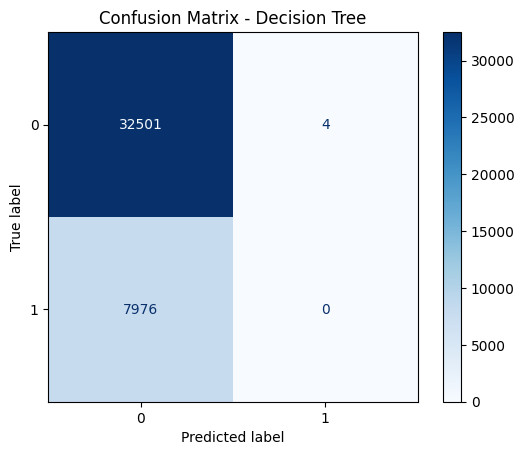


===== KNN =====
Best Parameters: {'n_neighbors': 11}
Accuracy: 0.7972135075714533
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     32505
           1       0.22      0.01      0.02      7976

    accuracy                           0.80     40481
   macro avg       0.51      0.50      0.45     40481
weighted avg       0.69      0.80      0.72     40481



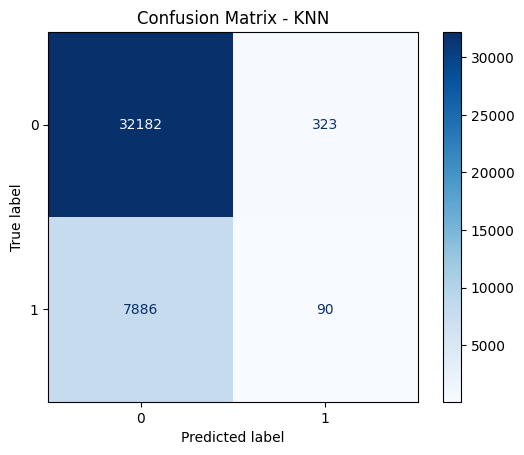


===== SVM =====
Best Parameters: {'C': 10}
Accuracy: 0.8029692942368024
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     32505
           1       0.00      0.00      0.00      7976

    accuracy                           0.80     40481
   macro avg       0.40      0.50      0.45     40481
weighted avg       0.64      0.80      0.72     40481



C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

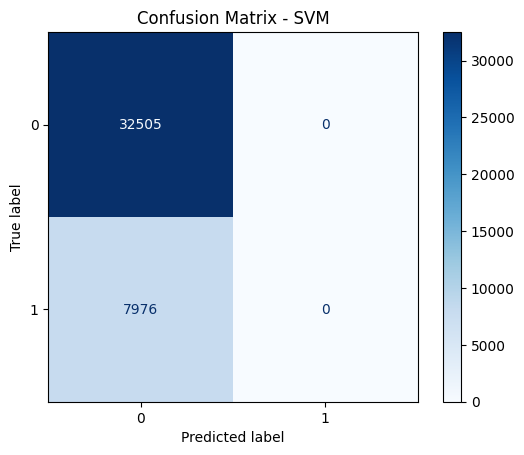

In [9]:

results = {}

for name, model in models.items():
    print(f"\n===== {name} =====")

    grid = HalvingGridSearchCV(
        model,
        param_grid[name],
        cv=3,
        factor=2,
        scoring="accuracy",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print("Best Parameters:", grid.best_params_)
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Model Comparison

In [13]:

print("\n=== Model Comparison ===")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")

best_model = max(results, key=results.get)


=== Model Comparison ===
Logistic Regression: 0.8030
Random Forest: 0.8030
Decision Tree: 0.8029
KNN: 0.7972
SVM: 0.8030


# Combined ROC Curve for All Models


Plotting ROC for Logistic Regression...
Plotting ROC for Random Forest...
Plotting ROC for Decision Tree...
Plotting ROC for KNN...
Plotting ROC for SVM...


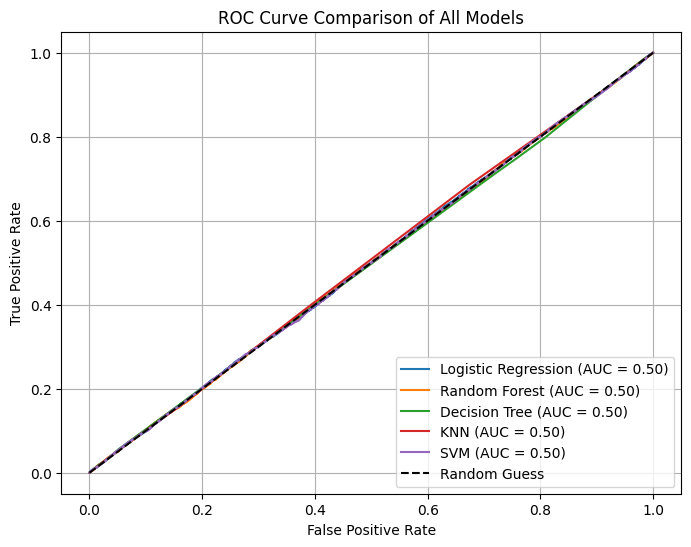

In [14]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for name, model in models.items():
    print(f"Plotting ROC for {name}...")

    # Refit model with best params (if not already)
    grid = HalvingGridSearchCV(
        model,
        param_grid[name],
        cv=3,
        factor=2,
        scoring="accuracy",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    # Predict probabilities or decision function
    if hasattr(best_model, "predict_proba"):
        y_scores = best_model.predict_proba(X_test)[:, 1]
    elif hasattr(best_model, "decision_function"):
        y_scores = best_model.decision_function(X_test)
    else:
        y_scores = best_model.predict(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plot baseline
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.title("ROC Curve Comparison of All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Top 10 Products, Top 10 Customers & Monthly Sales Trend (Fixed for Your Dataset)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 🏆 Top 10 Product Categories ---
if all(col in df.columns for col in ["Product Category", "Quantity"]):
    top_products = (
        df.groupby("Product Category")["Quantity"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_products.values, y=top_products.index, palette="viridis")
    plt.title("Top 10 Product Categories by Quantity Sold")
    plt.xlabel("Total Quantity Sold")
    plt.ylabel("Product Category")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 'Product Category' or 'Quantity' not found.")

# --- 💰 Top 10 Customers by Spending ---
if all(col in df.columns for col in ["Customer ID", "Total Purchase Amount"]):
    top_customers = (
        df.groupby("Customer ID")["Total Purchase Amount"]
        .sum()
        .sort_values(ascending=False)
        .head(10)
    )

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_customers.values, y=top_customers.index, palette="mako")
    plt.title("Top 10 Customers by Total Purchase Amount")
    plt.xlabel("Total Spending")
    plt.ylabel("Customer ID")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 'Customer ID' or 'Total Purchase Amount' not found.")

# --- 📅 Monthly Sales Trend ---
if all(col in df.columns for col in ["Purchase Date", "Total Purchase Amount"]):
    df["Purchase Date"] = pd.to_datetime(df["Purchase Date"], errors="coerce")
    monthly_sales = (
        df.groupby(df["Purchase Date"].dt.to_period("M"))["Total Purchase Amount"]
        .sum()
        .reset_index()
    )
    monthly_sales["Purchase Date"] = monthly_sales["Purchase Date"].astype(str)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Purchase Date", y="Total Purchase Amount", data=monthly_sales, palette="cubehelix")
    plt.title("Monthly Sales Trend")
    plt.xlabel("Month")
    plt.ylabel("Total Sales")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 'Purchase Date' or 'Total Purchase Amount' not found.")

# Product Recommendation Phase (Testing)

In [ ]:
# Let's assume we have a customer ID for testing
test_customer_id = df["Customer ID"].sample(1).values[0]
print(f"\n🧍‍♂️ Showing recommendations for Customer ID: {test_customer_id}")

# Get all products purchased by this customer
customer_products = df[df["Customer ID"] == test_customer_id]["Product Category"].unique()

print(f"\n🛍️ Products previously purchased by customer: {list(customer_products)}")

# Find other customers who bought similar products
similar_customers = df[df["Product Category"].isin(customer_products)]["Customer ID"].unique()

# Find new products those similar customers bought (that our customer hasn’t bought yet)
recommended_products = (
    df[df["Customer ID"].isin(similar_customers) & 
       ~df["Product Category"].isin(customer_products)]["Product Category"]
    .value_counts()
    .head(5)
)

if not recommended_products.empty:
    print("\n💡 Recommended Products based on similar customer behavior:")
    for product, count in recommended_products.items():
        print(f"   - {product} (bought by {count} similar customers)")

    # Plot bar chart of recommendations
    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8,5))
    sns.barplot(x=recommended_products.values, y=recommended_products.index, palette="crest")
    plt.title(f"Recommended Products for Customer ID: {test_customer_id}")
    plt.xlabel("Popularity (among similar customers)")
    plt.ylabel("Product Category")
    plt.tight_layout()
    plt.show()

else:
    print("\n⚠️ Not enough data to generate recommendations for this customer.")

# Product Recommendation System (Manual Input)


Enter Customer ID to get recommendations: 1656

🧍‍♂️ Showing recommendations for Customer ID: 1656

🛍️ Products previously purchased by customer: ['Books', 'Clothing']

💡 Recommended Products based on similar customer behavior:
   - Electronics (bought by 37102 similar customers)
   - Home (bought by 36731 similar customers)


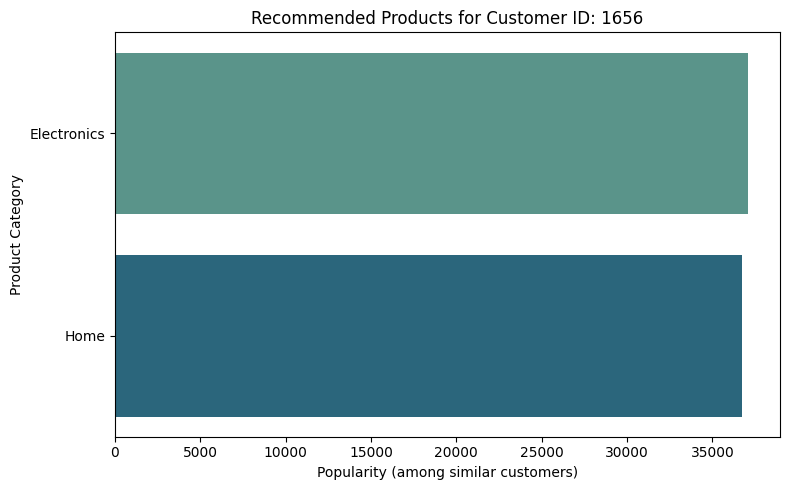

In [30]:

import matplotlib.pyplot as plt
import seaborn as sns

# Ask the user for a customer ID manually
customer_id = int(input("Enter Customer ID to get recommendations: "))

# Check if the entered Customer ID exists
if customer_id in df["Customer ID"].values:
    # Get all products purchased by this customer
    customer_products = df[df["Customer ID"] == customer_id]["Product Category"].unique()

    print(f"\n🧍‍♂️ Showing recommendations for Customer ID: {customer_id}")
    print(f"\n🛍️ Products previously purchased by customer: {list(customer_products)}")

    # Find other customers who bought similar products
    similar_customers = df[df["Product Category"].isin(customer_products)]["Customer ID"].unique()

    # Find products those similar customers bought (excluding already purchased ones)
    recommended_products = (
        df[df["Customer ID"].isin(similar_customers) &
           ~df["Product Category"].isin(customer_products)]["Product Category"]
        .value_counts()
        .head(5)
    )

    # Display recommendations
    if not recommended_products.empty:
        print("\n💡 Recommended Products based on similar customer behavior:")
        for product, count in recommended_products.items():
            print(f"   - {product} (bought by {count} similar customers)")

        # Plot bar chart of recommendations
        plt.figure(figsize=(8, 5))
        sns.barplot(x=recommended_products.values, y=recommended_products.index, palette="crest")
        plt.title(f"Recommended Products for Customer ID: {customer_id}")
        plt.xlabel("Popularity (among similar customers)")
        plt.ylabel("Product Category")
        plt.tight_layout()
        plt.show()

    else:
        print("\n⚠️ Not enough data to generate recommendations for this customer.")
else:
    print("❌ Customer ID not found in the dataset.")

## 🧠 FINAL TESTING PHASE with Random Forest & Recommendation System 


Enter Customer ID to get prediction & recommendations: 35737

🧍 Checking purchase likelihood for Customer ID: 35737

🧠 Average purchase probability = 0.37 (max row = 0.37) | Threshold = 0.35

🛍️ Products previously purchased by customer: ['Books', 'Electronics']

✅ Model Prediction: Customer 35737 is LIKELY to make a purchase.

💡 Recommended Products based on similar customer behavior:
   - Clothing (bought by 52760 similar customers)
   - Home (bought by 34988 similar customers)


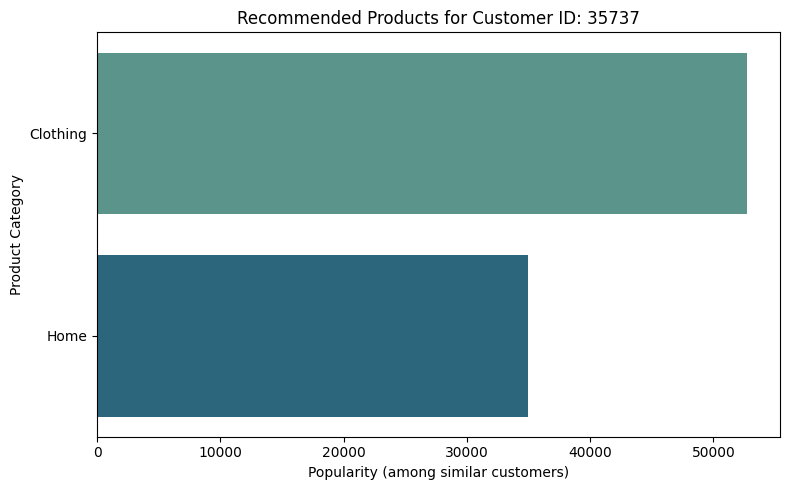

In [42]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# --- Retrain best model (Random Forest) ---
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)

# --- Handle any column case differences ---
df.columns = df.columns.str.strip()
X.columns = X.columns.str.strip()
customer_id_col = None

# Detect the correct column name for customer ID
for col in df.columns:
    if col.lower() == "customer id":
        customer_id_col = col
        break

if customer_id_col is None:
    raise KeyError("⚠️ No column found matching 'Customer ID' in dataset.")

# --- Ask for Customer ID ---
customer_id = int(input("Enter Customer ID to get prediction & recommendations: "))

# --- Check if the entered Customer ID exists ---
if customer_id in df[customer_id_col].values:
    print(f"\n🧍 Checking purchase likelihood for Customer ID: {customer_id}")

    # Extract all rows for this customer
    customer_rows = df[df[customer_id_col] == customer_id].copy()

    # Drop non-numeric or irrelevant columns automatically
    non_numeric_cols = [
        "Purchased", "Customer Name", "Gender", "Payment Method",
        "Product Category", "Purchase Date", "Churn", "Returns"
    ]
    customer_rows = customer_rows.drop(columns=[c for c in non_numeric_cols if c in customer_rows.columns], errors="ignore")

    # Keep numeric columns only
    customer_rows = customer_rows.select_dtypes(include=[np.number])

    # --- Align columns exactly as seen during training ---
    trained_feature_names = list(scaler.feature_names_in_)
    customer_rows = customer_rows.reindex(columns=trained_feature_names, fill_value=0)

    # --- Scale using the same scaler ---
    customer_scaled = scaler.transform(customer_rows)

    # --- Predict probabilities ---
    row_probs = best_model.predict_proba(customer_scaled)[:, 1]
    prob_mean = float(np.mean(row_probs))
    prob_max = float(np.max(row_probs))

    THRESHOLD = 0.35
    will_buy = prob_mean >= THRESHOLD

    print(f"\n🧠 Average purchase probability = {prob_mean:.2f} (max row = {prob_max:.2f}) | Threshold = {THRESHOLD:.2f}")

    # --- Recommendation Part ---
    # Detect correct column for product category
    prod_col = None
    for col in df.columns:
        if col.lower() == "product category":
            prod_col = col
            break

    customer_products = df[df[customer_id_col] == customer_id][prod_col].unique()
    print(f"\n🛍️ Products previously purchased by customer: {list(customer_products)}")

    similar_customers = df[df[prod_col].isin(customer_products)][customer_id_col].unique()

    recommended_products = (
        df[df[customer_id_col].isin(similar_customers) &
           ~df[prod_col].isin(customer_products)][prod_col]
        .value_counts()
        .head(5)
    )

    # --- Display Results ---
    if will_buy:
        print(f"\n✅ Model Prediction: Customer {customer_id} is LIKELY to make a purchase.")
        print("\n💡 Recommended Products based on similar customer behavior:")
        palette = "crest"
    else:
        print(f"\n❌ Model Prediction: Customer {customer_id} is UNLIKELY to make a purchase.")
        print("However, if re-engaged, we would recommend these categories:\n")
        palette = "flare"

    for product, count in recommended_products.items():
        print(f"   - {product} (bought by {count} similar customers)")

    if not recommended_products.empty:
        plt.figure(figsize=(8, 5))
        sns.barplot(x=recommended_products.values, y=recommended_products.index, palette=palette)
        plt.title(f"Recommended Products for Customer ID: {customer_id}")
        plt.xlabel("Popularity (among similar customers)")
        plt.ylabel("Product Category")
        plt.tight_layout()
        plt.show()

else:
    print("❌ Customer ID not found in the dataset.")
